<a href="https://colab.research.google.com/github/minahil-hassan/crypto-dashboard/blob/main/Crypto_Anomalies_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🪙 Cryptocurrency Market Data Analysis and Anomaly Detection (Last 90 Days)

This notebook retrieves, processes and analyses daily **price**, **volume** data for Bitcoin and Ethereum using the [CoinGecko API](https://www.coingecko.com/en/api/documentation) by following a modular approach with the steps detailed below:


**1. Data Source**  
  Retrieved 90 days of daily price, volume, and market cap data for Bitcoin (BTC) and Ethereum (ETH) using the CoinGecko API.

**2. Preprocessing**  
  Converted raw values to millions of USD, calculated daily percentage changes in price and volume, removed NaNs, and saved cleaned data to CSV files.

**3. Distribution Assessment**  
  Plotted histograms of price and volume data with overlaid Gaussian (normal) curves to visually assess distributional assumptions.

**4. Univariate Price Anomaly Detection**  
  Flagged days where absolute daily price change exceeded ±5% to establish baseline price volatility anomalies.

**5. Feature Selection for Multivariate Analysis**  
  Selected `["Price Change (%)", "Volume Change (%)"]` as the feature set for joint modeling of market behavior.

**6. Multivariate Anomaly Detection Methods**  
  Applied two unsupervised multivariate techniques:  
  - **Local Outlier Factor (LOF)**  
  - **Isolation Forest (IF)**

**7. Anomaly Classification**  
  Introduced binary anomaly flags:  
  - **Hybrid Multivariate Anomaly** = flagged by either LOF or IF  
  - **High Confidence Multivariate** = flagged by both LOF and IF

**8. Anomaly Direction Tagging**  
  Labeled each hybrid anomaly as **Increase**, **Decrease**, or **Neutral** based on the sign of `Price Change (%)`.

**9. Volume–Price Timing Analysis**  
  Compared timing of volume anomalies with price anomalies to identify whether volume changes typically lead, lag, or coincide with price shifts. Reported average lead/lag durations.

**10. Cross-Asset Lead–Lag Analysis**  
  Analyzed multivariate anomalies in BTC vs ETH to determine:  
  - How often anomalies occur on the same day  
  - Which asset tends to lead  
  - Directional breakdown (increase vs decrease)

**11. Anomaly Reporting**  
  Reported total anomaly counts and detection rates for LOF, IF, hybrid, and high confidence classifications, along with example anomaly events.

**12. Visualisation**  
  Created a range of visual outputs including:  
  - Histograms with normal overlays  
  - Time series of price and volume changes  
  - Dual-axis price-volume plots  
  - Price anomaly plots per asset  
  - Combined BTC vs ETH anomaly comparison plots

In [ ]:
#imports
import requests
import pandas as pd
from datetime import datetime
import os
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt

##  Fetch Data from CoinGecko API

We retrieve 90 days of daily **price**, **volume**, and **market capitalization** data for Bitcoin and Ethereum using CoinGecko’s public API.


In [ ]:
# Define CoinGecko API URL for Bitcoin
urlB = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=90&interval=daily"

# Request data
responseB = requests.get(urlB)
dataB = responseB.json()

In [ ]:
# Define CoinGecko API URL for Ethereum
urlE = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=90&interval=daily"

# Request data
responseE = requests.get(urlE)
dataE = responseE.json()


## Extract and Format Time Series

We convert the raw JSON responses into Python dictionaries mapping human-readable dates to values for each metric (price, volume, and market cap).


In [ ]:
def extract_series(data, series_name):
    """
    Extracts and converts a time series from the API response into a dict
    mapping datetime.date to value.
    """
    return {
        datetime.utcfromtimestamp(entry[0] / 1000).date(): entry[1]
        for entry in data[series_name]
    }

# Bitcoin
pricesB = extract_series(dataB, "prices")
volumes_B = extract_series(dataB, "total_volumes")
market_capsB = extract_series(dataB, "market_caps")

# Ethereum
pricesE = extract_series(dataE, "prices")
volumes_usdE = extract_series(dataE, "total_volumes")
market_capsE = extract_series(dataE, "market_caps")

# Build DataFrames, Convert to Millions, and Save
We create DataFrames for each coin, convert to millions, and save to CSV files.


In [ ]:
def build_and_save_crypto_df(prices, volumes, market_caps, coin_name):
    """
    Build DataFrame from price, volume, market cap data and save to CSV.
    Also prints original and converted (million USD) values.
    """
    # Build initial DataFrame with original values
    df = pd.DataFrame({
        "Date": list(prices.keys()),
        "Price (USD)": list(prices.values()),
        "Volume (USD)": [volumes[dt] for dt in prices],
        "Market Cap (USD)": [market_caps[dt] for dt in prices]
    })

    # Preview raw data
    print(f"\nOriginal data for {coin_name} (raw values):")
    print(df.head())

    # Convert values to millions
    df["Price (M USD)"] = df["Price (USD)"] / 1_000_000
    df["Volume (M USD)"] = df["Volume (USD)"] / 1_000_000
    df["Market Cap (M USD)"] = df["Market Cap (USD)"] / 1_000_000

    # Rename columns and reorder
    million_df = df[["Date", "Price (M USD)", "Volume (M USD)", "Market Cap (M USD)"]]

    # Preview converted data
    print(f"\nConverted data for {coin_name} (in millions):")
    print(million_df.head())

    # Save to CSV
    filename = f"{coin_name.lower()}.csv"
    million_df.to_csv(filename, index=False)
    print(f"{filename} saved successfully.")


In [ ]:
build_and_save_crypto_df(pricesB, volumes_B, market_capsB, "Bitcoin")
build_and_save_crypto_df(pricesE, volumes_usdE, market_capsE, "Ethereum")


Original data for Bitcoin (raw values):
         Date   Price (USD)  Volume (USD)  Market Cap (USD)
0  2025-02-26  88755.769336  9.674245e+10      1.759750e+12
1  2025-02-27  83900.114965  6.927743e+10      1.664315e+12
2  2025-02-28  84709.144778  3.051904e+11      1.679555e+12
3  2025-03-01  84441.901224  8.069524e+10      1.674754e+12
4  2025-03-02  86005.256297  3.063447e+10      1.705564e+12

Converted data for Bitcoin (in millions):
         Date  Price (M USD)  Volume (M USD)  Market Cap (M USD)
0  2025-02-26       0.088756    96742.453403        1.759750e+06
1  2025-02-27       0.083900    69277.430796        1.664315e+06
2  2025-02-28       0.084709   305190.442157        1.679555e+06
3  2025-03-01       0.084442    80695.237175        1.674754e+06
4  2025-03-02       0.086005    30634.474723        1.705564e+06
bitcoin.csv saved successfully.

Original data for Ethereum (raw values):
         Date  Price (USD)  Volume (USD)  Market Cap (USD)
0  2025-02-26  2495.315452  4.287

## Visualize Distribution of Price and Volume

Before applying anomaly detection, we examine whether the price and volume data for Bitcoin and Ethereum follow a normal (Gaussian) distribution.

For each metric:
- A **histogram** shows the actual distribution of values.
- A **red dashed line** overlays the corresponding **normal probability density function (PDF)** with the same mean and standard deviation.

This helps visually assess whether methods based on Z-score or other assumptions of normality are appropriate.


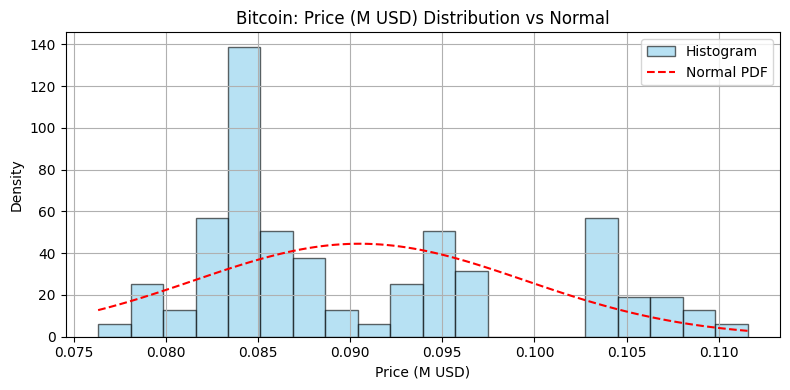

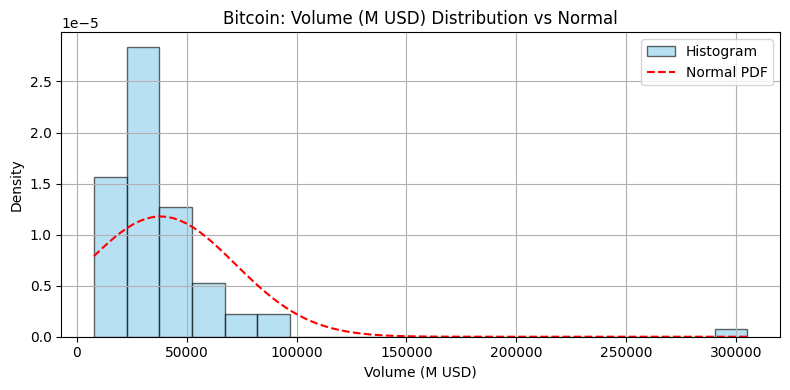

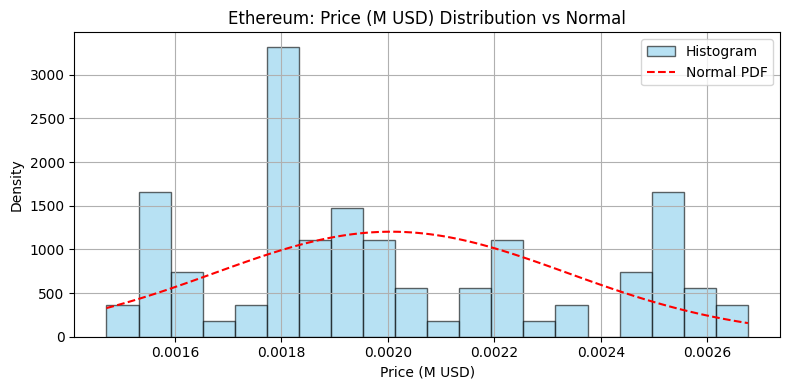

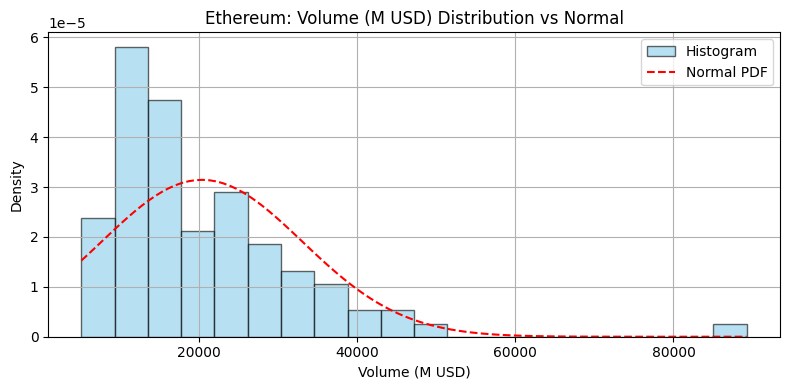

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Load CSVs created earlier
btc_df = pd.read_csv("bitcoin.csv")
eth_df = pd.read_csv("ethereum.csv")

def plot_hist_with_normal_overlay(df, column, asset_label):
    """
    Plots histogram with normal distribution overlay for a given column.
    """
    data = df[column].dropna()
    mean = data.mean()
    std = data.std()

    # Histogram
    plt.figure(figsize=(8, 4))
    count, bins, ignored = plt.hist(data, bins=20, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Histogram')

    # Normal distribution curve
    x = np.linspace(min(data), max(data), 100)
    pdf = norm.pdf(x, mean, std)
    plt.plot(x, pdf, 'r--', label='Normal PDF')

    plt.title(f"{asset_label}: {column} Distribution vs Normal")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot histograms + overlays
for df, label in [(btc_df, "Bitcoin"), (eth_df, "Ethereum")]:
    plot_hist_with_normal_overlay(df, "Price (M USD)", label)
    plot_hist_with_normal_overlay(df, "Volume (M USD)", label)


## Detect Price changes > 5%

We calculate daily percentage changes in price and flag anomalies where the absolute change exceeds a specified threshold (e.g., 5%).


In [ ]:
def detect_price_anomalies(csv_path, threshold=10):
    """
    Load CSV, calculate daily price % change, and flag anomalies > threshold.
    """
    df = pd.read_csv(csv_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").set_index("Date")

    # Calculate daily % price change
    df["Price Change (%)"] = df["Price (M USD)"].pct_change() * 100

    # Flag anomalies where absolute % change > threshold
    df["Price Anomaly (>±{}%)".format(threshold)] = df["Price Change (%)"].abs() > threshold

    # Drop initial NaN
    df = df.dropna(subset=["Price Change (%)"])

    # Print anomalies
    anomalies = df[df["Price Anomaly (>±{}%)".format(threshold)]]
    print(f"\n{csv_path} — {len(anomalies)} anomalies detected where |% change| > {threshold}%")
    print(anomalies[["Price (M USD)", "Price Change (%)"]])

    return df, anomalies


In [ ]:
# Run the anomaly detection function for BTC and ETH
btc_df, btc_anomalies = detect_price_anomalies("bitcoin.csv", threshold=5)
eth_df, eth_anomalies = detect_price_anomalies("ethereum.csv", threshold=5)


bitcoin.csv — 9 anomalies detected where |% change| > 5%
            Price (M USD)  Price Change (%)
Date                                       
2025-02-27       0.083900         -5.470804
2025-03-03       0.094262          9.599735
2025-03-04       0.086125         -8.632173
2025-03-10       0.080751         -6.259180
2025-03-12       0.082799          5.096429
2025-04-07       0.078211         -6.440989
2025-04-10       0.082622          8.244668
2025-04-23       0.093576          7.002831
2025-05-09       0.103076          6.235185

ethereum.csv — 18 anomalies detected where |% change| > 5%
            Price (M USD)  Price Change (%)
Date                                       
2025-02-27       0.002326         -6.791186
2025-03-03       0.002517         13.761322
2025-03-04       0.002148        -14.663850
2025-03-10       0.002017         -8.306095
2025-03-11       0.001879         -6.848001
2025-03-20       0.002061          6.619021
2025-03-29       0.001897         -5.310532
20

## Volume vs Price Anomaly Timing

This section investigates whether significant volume changes occur before, after, or on the same day as price anomalies — helping identify potential predictive volume behavior.


In [ ]:
def compare_price_volume_anomaly_timing(df, asset_label, price_anomalies, volume_threshold=20):
    """
    Compares timing of volume % anomalies relative to price % anomalies.
    Volume anomaly defined as absolute volume change > threshold (e.g. 20%).
    Now includes percentage breakdown.
    """
    # Calculate % volume change and flag volume anomalies
    df["Volume Change (%)"] = df["Volume (M USD)"].pct_change() * 100
    df["Volume Anomaly"] = df["Volume Change (%)"].abs() > volume_threshold

    price_anom_dates = price_anomalies.index
    vol_anom_dates = df[df["Volume Anomaly"]].index
    total_price_anoms = len(price_anom_dates)

    # === 1. Same-day anomalies
    same_day = price_anom_dates.intersection(vol_anom_dates)

    # === 2. Volume leads price
    vol_leads = []
    for price_date in price_anom_dates:
        previous_vol = [d for d in vol_anom_dates if d < price_date]
        if previous_vol:
            latest_vol = max(previous_vol)
            vol_leads.append((latest_vol, price_date, (price_date - latest_vol).days))

    # === 3. Volume lags price
    vol_lags = []
    for price_date in price_anom_dates:
        next_vol = [d for d in vol_anom_dates if d > price_date]
        if next_vol:
            soonest_vol = min(next_vol)
            vol_lags.append((price_date, soonest_vol, (soonest_vol - price_date).days))

    # === Report
    print(f"\n {asset_label}: Volume vs Price % Change Anomaly Timing")
    print(f" Total price anomalies: {total_price_anoms}")

    if total_price_anoms > 0:
        print(f" Same-day volume anomalies: {len(same_day)} ({len(same_day)/total_price_anoms:.1%})")
        print(f" Volume before price: {len(vol_leads)} ({len(vol_leads)/total_price_anoms:.1%})")
        print(f" Volume after price: {len(vol_lags)} ({len(vol_lags)/total_price_anoms:.1%})")
    else:
        print(" No price anomalies to compare.")

    if vol_leads:
        avg_lead = sum([d for _, _, d in vol_leads]) / len(vol_leads)
        print(f"   - Avg lead time: {avg_lead:.2f} days")

    if vol_lags:
        avg_lag = sum([d for _, _, d in vol_lags]) / len(vol_lags)
        print(f"   - Avg lag time: {avg_lag:.2f} days")

    return same_day, vol_leads, vol_lags
btc_same_vol, btc_vol_leads, btc_vol_lags = compare_price_volume_anomaly_timing(btc_df, "Bitcoin", btc_anomalies)
eth_same_vol, eth_vol_leads, eth_vol_lags = compare_price_volume_anomaly_timing(eth_df, "Ethereum", eth_anomalies)



 Bitcoin: Volume vs Price % Change Anomaly Timing
 Total price anomalies: 9
 Same-day volume anomalies: 6 (66.7%)
 Volume before price: 8 (88.9%)
 Volume after price: 9 (100.0%)
   - Avg lead time: 1.00 days
   - Avg lag time: 1.56 days

 Ethereum: Volume vs Price % Change Anomaly Timing
 Total price anomalies: 18
 Same-day volume anomalies: 14 (77.8%)
 Volume before price: 17 (94.4%)
 Volume after price: 18 (100.0%)
   - Avg lead time: 1.41 days
   - Avg lag time: 1.67 days


## Visualize Price and Volume Trends

We generate visualizations for daily % change in price and volume, and dual-axis plots to show co-movement or divergence between price and volume over time.


In [ ]:

# Calculate Volume % Change
btc_df["Volume Change (%)"] = btc_df["Volume (M USD)"].pct_change() * 100
eth_df["Volume Change (%)"] = eth_df["Volume (M USD)"].pct_change() * 100

# Drop any resulting NaNs
btc_df.dropna(subset=["Volume Change (%)"], inplace=True)
eth_df.dropna(subset=["Volume Change (%)"], inplace=True)

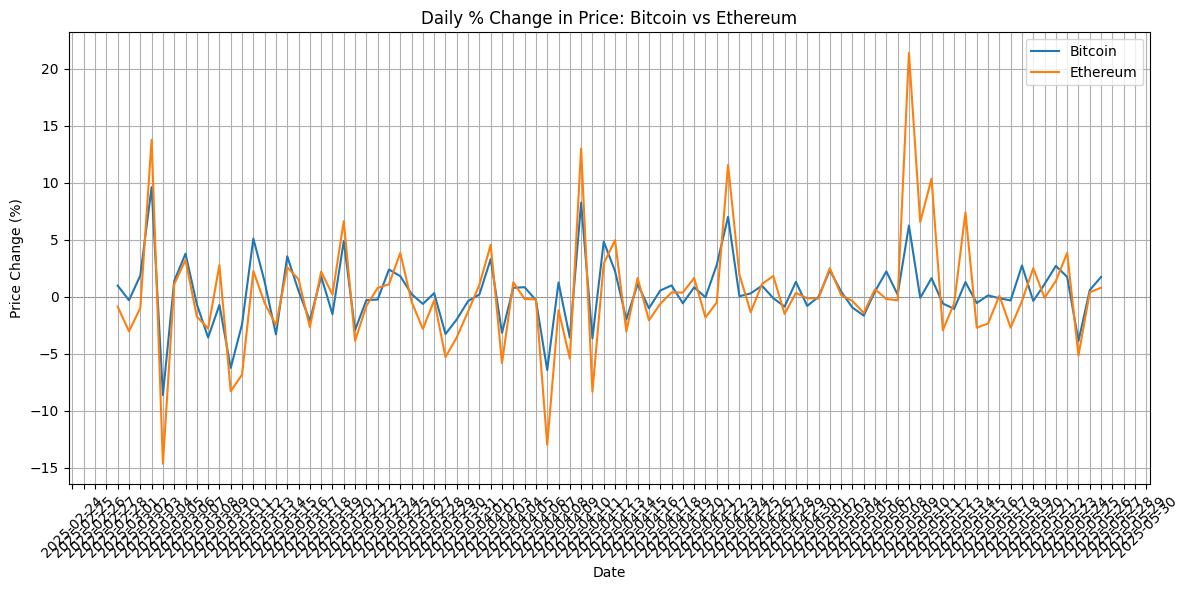

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(btc_df.index, btc_df["Price Change (%)"], label="Bitcoin", linewidth=1.5)
plt.plot(eth_df.index, eth_df["Price Change (%)"], label="Ethereum", linewidth=1.5)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.title("Daily % Change in Price: Bitcoin vs Ethereum")
plt.xlabel("Date")
plt.ylabel("Price Change (%)")
plt.legend()
plt.grid(True)

# Force daily ticks
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Daily ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format

plt.xticks(rotation=45)  # Rotate for readability
plt.tight_layout()
plt.show()


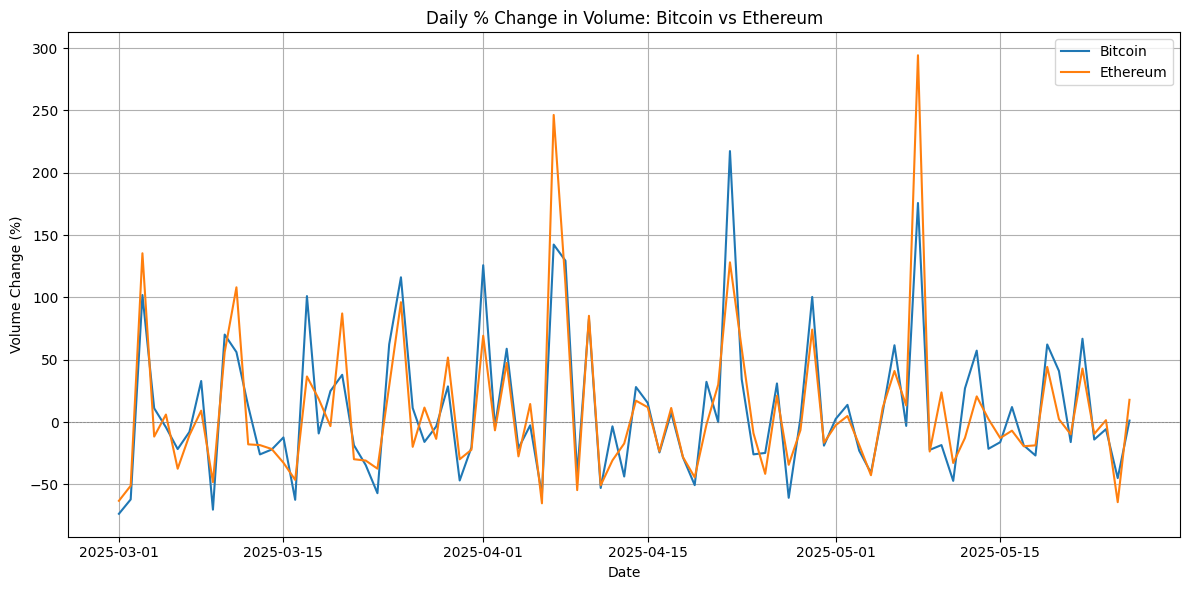

In [ ]:
# === PLOT: Daily % Volume Change ===
plt.figure(figsize=(12, 6))
plt.plot(btc_df.index, btc_df["Volume Change (%)"], label="Bitcoin", linewidth=1.5)
plt.plot(eth_df.index, eth_df["Volume Change (%)"], label="Ethereum", linewidth=1.5)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.title("Daily % Change in Volume: Bitcoin vs Ethereum")
plt.xlabel("Date")
plt.ylabel("Volume Change (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

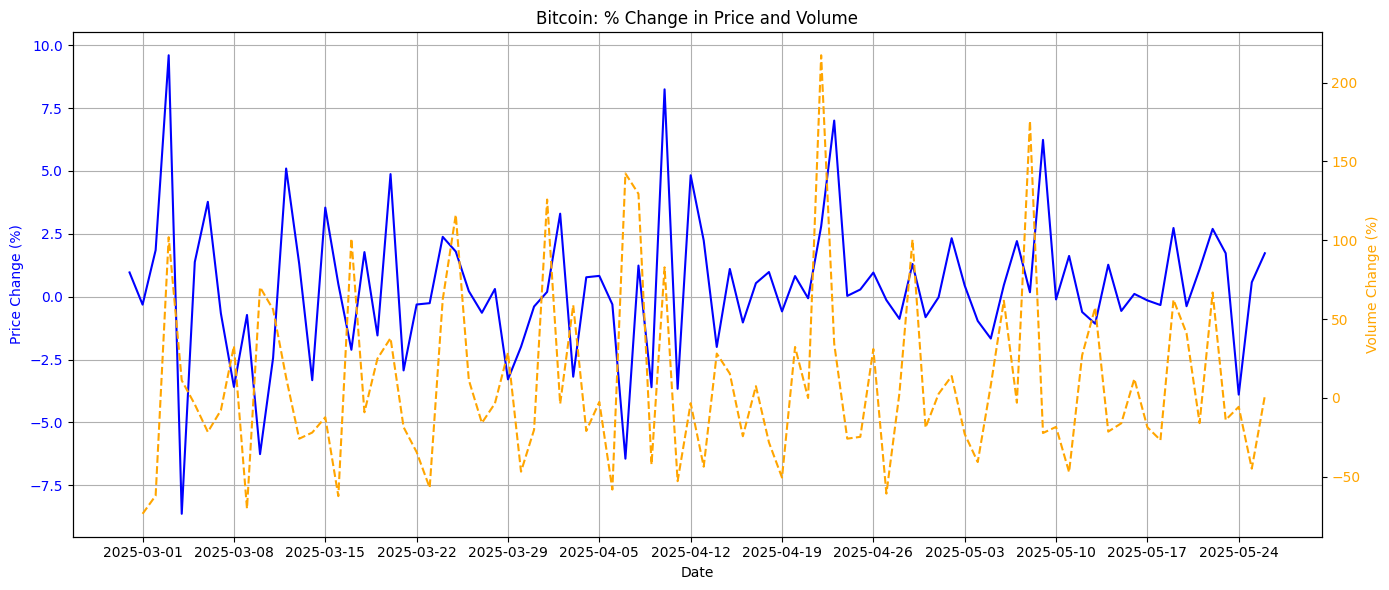

In [ ]:
import matplotlib.dates as mdates

# --- BITCOIN: Price and Volume % Change ---
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_title("Bitcoin: % Change in Price and Volume")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price Change (%)", color='blue')
ax1.plot(btc_df.index, btc_df["Price Change (%)"], color='blue', label="Price % Change", linewidth=1.5)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel("Volume Change (%)", color='orange')
ax2.plot(btc_df.index, btc_df["Volume Change (%)"], color='orange', linestyle='--', label="Volume % Change", linewidth=1.5)
ax2.tick_params(axis='y', labelcolor='orange')
ax2.grid(False)

# Daily x-axis ticks and formatting
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()


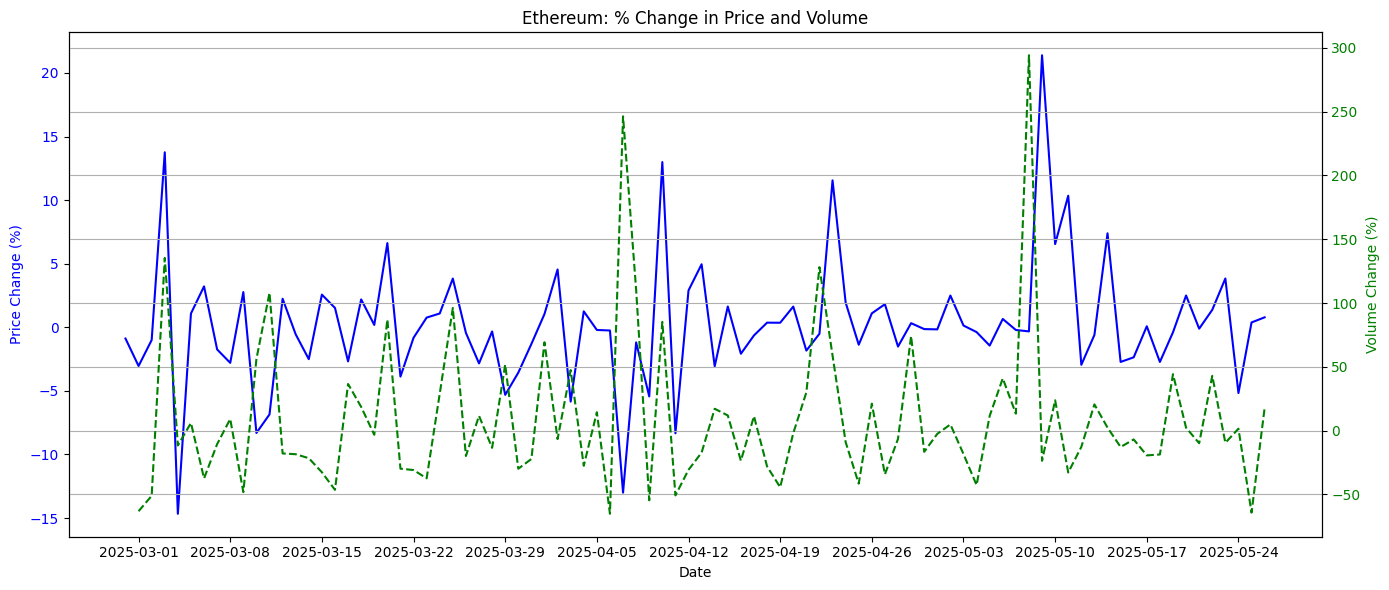

In [ ]:
# --- ETHEREUM: Price and Volume % Change ---
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_title("Ethereum: % Change in Price and Volume")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price Change (%)", color='blue')
ax1.plot(eth_df.index, eth_df["Price Change (%)"], color='blue', label="Price % Change", linewidth=1.5)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel("Volume Change (%)", color='green')
ax2.plot(eth_df.index, eth_df["Volume Change (%)"], color='green', linestyle='--', label="Volume % Change", linewidth=1.5)
ax2.tick_params(axis='y', labelcolor='green')

ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
fig.tight_layout()
plt.grid(True)
plt.show()


#Multi Variate Approach

## Multivariate Anomaly Detection (LOF + Isolation Forest)

To detect unusual market behavior, we apply two unsupervised anomaly detection algorithms jointly on both features:

- **Local Outlier Factor (LOF)**: A proximity-based method that detects anomalies by comparing local density.
- **Isolation Forest (IF)**: A tree-based ensemble method that isolates anomalies through recursive partitioning.

Both models are applied using `["Price Change (%)", "Volume Change (%)"]` as a multivariate feature set.


In [ ]:
def apply_lof_multivariate(df, feature_cols, n_neighbors=7, contamination=0.05):
    """
    Apply Local Outlier Factor to multiple features (e.g., price and volume).
    Adds a column 'LOF Multivariate Anomaly'.
    """
    feature_data = df[feature_cols].dropna()
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    labels = lof.fit_predict(feature_data)

    # Align with original dataframe
    df["LOF Multivariate Anomaly"] = False
    df.loc[feature_data.index, "LOF Multivariate Anomaly"] = (labels == -1)
    return df


In [ ]:
def apply_isolation_forest_multivariate(df, feature_cols, n_estimators=100, contamination=0.05):
    """
    Apply Isolation Forest on multiple features.
    Adds a column 'IF Multivariate Anomaly'.
    """
    feature_data = df[feature_cols].dropna()
    iforest = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=42)
    labels = iforest.fit_predict(feature_data)

    df["IF Multivariate Anomaly"] = False
    df.loc[feature_data.index, "IF Multivariate Anomaly"] = (labels == -1)
    return df


In [ ]:
btc_df = apply_lof_multivariate(btc_df, ["Price Change (%)", "Volume Change (%)"])
btc_df = apply_isolation_forest_multivariate(btc_df, ["Price Change (%)", "Volume Change (%)"])


## Create Hybrid and High-Confidence Anomaly Flags

We define two types of anomaly flags based on LOF and IF results:

- `Hybrid Multivariate Anomaly`: A day is flagged as an anomaly if **either LOF or IF** detects it.
- `High Confidence Multivariate`: A day is flagged only if **both LOF and IF** agree.

This dual-label strategy allows for flexibility in evaluating anomalies with different levels of certainty.


In [ ]:
btc_df["Hybrid Multivariate Anomaly"] = (
    btc_df["LOF Multivariate Anomaly"] | btc_df["IF Multivariate Anomaly"]
)
btc_df["High Confidence Multivariate"] = (
    btc_df["LOF Multivariate Anomaly"] & btc_df["IF Multivariate Anomaly"]
)


In [ ]:
eth_df = apply_lof_multivariate(eth_df, ["Price Change (%)", "Volume Change (%)"])
eth_df = apply_isolation_forest_multivariate(eth_df, ["Price Change (%)", "Volume Change (%)"])

eth_df["Hybrid Multivariate Anomaly"] = (
    eth_df["LOF Multivariate Anomaly"] | eth_df["IF Multivariate Anomaly"]
)
eth_df["High Confidence Multivariate"] = (
    eth_df["LOF Multivariate Anomaly"] & eth_df["IF Multivariate Anomaly"]
)

## Classify Anomalies as Increase or Decrease Events

Each anomaly is tagged with a direction label:

- **Increase**: If `Price Change (%)` is positive
- **Decrease**: If `Price Change (%)` is negative
- **Neutral**: If change is exactly zero (rare or theoretical)

This classification helps interpret the nature of the anomaly — whether it reflects bullish or bearish market behavior.


In [ ]:
# Add anomaly direction based on sign of price change
btc_df["Anomaly Direction"] = "Neutral"
btc_df.loc[
    btc_df["Hybrid Multivariate Anomaly"] & (btc_df["Price Change (%)"] > 0),
    "Anomaly Direction"
] = "Increase"

btc_df.loc[
    btc_df["Hybrid Multivariate Anomaly"] & (btc_df["Price Change (%)"] < 0),
    "Anomaly Direction"
] = "Decrease"

eth_df["Anomaly Direction"] = "Neutral"
eth_df.loc[
    eth_df["Hybrid Multivariate Anomaly"] & (eth_df["Price Change (%)"] > 0),
    "Anomaly Direction"
] = "Increase"

eth_df.loc[
    eth_df["Hybrid Multivariate Anomaly"] & (eth_df["Price Change (%)"] < 0),
    "Anomaly Direction"
] = "Decrease"


In [ ]:
def print_multivariate_anomaly_report(df, asset_label):
    total = len(df)
    lof_count = df["LOF Multivariate Anomaly"].sum()
    if_count = df["IF Multivariate Anomaly"].sum()
    hybrid = df["Hybrid Multivariate Anomaly"].sum()
    high_conf = df["High Confidence Multivariate"].sum()

    print(f"\n {asset_label} — Multivariate Anomaly Report")
    print(f"Total data points: {total}")
    print(f"LOF anomalies (joint price + volume): {lof_count} ({lof_count/total:.1%})")
    print(f"Isolation Forest anomalies:         {if_count} ({if_count/total:.1%})")
    print(f"Hybrid anomalies (LOF ∪ IF):        {hybrid} ({hybrid/total:.1%})")
    print(f"High-confidence anomalies (LOF ∩ IF): {high_conf} ({high_conf/total:.1%})")

    print("\nSample Hybrid Anomalies:")
    print(df[df["Hybrid Multivariate Anomaly"]][["Price Change (%)", "Volume Change (%)"]].head())


In [ ]:
print_multivariate_anomaly_report(btc_df, "Bitcoin")
print_multivariate_anomaly_report(eth_df, "Ethereum")



 Bitcoin — Multivariate Anomaly Report
Total data points: 88
LOF anomalies (joint price + volume): 5 (5.7%)
Isolation Forest anomalies:         5 (5.7%)
Hybrid anomalies (LOF ∪ IF):        8 (9.1%)
High-confidence anomalies (LOF ∩ IF): 2 (2.3%)

Sample Hybrid Anomalies:
            Price Change (%)  Volume Change (%)
Date                                           
2025-03-03          9.599735         101.926467
2025-03-04         -8.632173          11.083654
2025-03-22         -0.310084         -34.403273
2025-04-07         -6.440989         142.383686
2025-04-10          8.244668          82.813479

 Ethereum — Multivariate Anomaly Report
Total data points: 88
LOF anomalies (joint price + volume): 5 (5.7%)
Isolation Forest anomalies:         5 (5.7%)
Hybrid anomalies (LOF ∪ IF):        6 (6.8%)
High-confidence anomalies (LOF ∩ IF): 4 (4.5%)

Sample Hybrid Anomalies:
            Price Change (%)  Volume Change (%)
Date                                           
2025-03-03         13.7

## Lead–Lag Analysis with Anomaly Direction (Increase/Decrease)

This analysis investigates the **temporal relationship** between multivariate anomaly events in Bitcoin and Ethereum. Specifically, it answers:

1.  **Do anomalies in BTC and ETH occur on the same day?**
2.  **Does one asset consistently lead the other in anomaly behavior?**
3.  **Are the anomalies increases or decreases in price?**




We use previously detected **hybrid multivariate anomalies** (using LOF and Isolation Forest on both price and volume change). For each anomaly:

- We identify the **date of the event**.
- We classify the event as an **increase** or **decrease**, based on the sign of the price change.
- For every BTC anomaly, we check whether there was a **prior ETH anomaly** — and vice versa.
- The **gap (in days)** between the anomaly in one asset and the most recent prior anomaly in the other is recorded.
- Directional counts (increase vs decrease) are also tracked for each lead case.



### Output Interpretation

The analysis prints:

- Number of **same-day anomalies** between BTC and ETH
- Count and **average lead time** (in days) where:
  - **ETH anomaly led BTC**
    - How many were price **increases**
    - How many were price **decreases**
  - **BTC anomaly led ETH**
    - Similarly broken down by direction


### Insights This Can Reveal

- **Predictive Power**: If ETH anomalies often precede BTC anomalies — especially during price increases — it might suggest ETH is an early signal for BTC movements.
- **Market Behavior**: More "decrease" anomalies leading another asset may indicate cascading effects or panic selling.
- **Asymmetry**: If BTC frequently leads ETH but not vice versa, this may support BTC’s role as a primary mover in crypto markets.
- **Confirmation**: Same-day anomalies indicate synchronized behavior, suggesting common macro drivers or high correlation.


This adds **contextual richness** to anomaly detection, turning raw detection signals into **interpretable market intelligence**.


In [ ]:
def compare_multivariate_anomalies_with_gap_and_direction(btc_df, eth_df):
    btc_anoms = btc_df[btc_df["Hybrid Multivariate Anomaly"]]
    eth_anoms = eth_df[eth_df["Hybrid Multivariate Anomaly"]]

    btc_dates = btc_anoms.index
    eth_dates = eth_anoms.index

    same_day = btc_dates.intersection(eth_dates)
    print(f"\nCommon BTC–ETH Anomalies: {len(same_day)} days")
    print(sorted(same_day))

    # ETH leads BTC
    eth_leads = []
    eth_leads_dir = {"Increase": 0, "Decrease": 0}
    for btc_date in btc_dates:
        prev_eth = eth_dates[eth_dates < btc_date]
        if not prev_eth.empty:
            latest_eth = max(prev_eth)
            days_gap = (btc_date - latest_eth).days
            eth_leads.append(days_gap)

            direction = eth_anoms.loc[latest_eth, "Anomaly Direction"]
            if direction in eth_leads_dir:
                eth_leads_dir[direction] += 1

    # BTC leads ETH
    btc_leads = []
    btc_leads_dir = {"Increase": 0, "Decrease": 0}
    for eth_date in eth_dates:
        prev_btc = btc_dates[btc_dates < eth_date]
        if not prev_btc.empty:
            latest_btc = max(prev_btc)
            days_gap = (eth_date - latest_btc).days
            btc_leads.append(days_gap)

            direction = btc_anoms.loc[latest_btc, "Anomaly Direction"]
            if direction in btc_leads_dir:
                btc_leads_dir[direction] += 1

    # Print ETH leads BTC
    print(f"\n📈 ETH anomalies led BTC {len(eth_leads)} times.")
    if eth_leads:
        print(f" - Avg lead time: {sum(eth_leads)/len(eth_leads):.2f} days")
        print(f" - Increases: {eth_leads_dir['Increase']}")
        print(f" - Decreases: {eth_leads_dir['Decrease']}")

    # Print BTC leads ETH
    print(f"\n📉 BTC anomalies led ETH {len(btc_leads)} times.")
    if btc_leads:
        print(f" - Avg lead time: {sum(btc_leads)/len(btc_leads):.2f} days")
        print(f" - Increases: {btc_leads_dir['Increase']}")
        print(f" - Decreases: {btc_leads_dir['Decrease']}")
compare_multivariate_anomalies_with_gap_and_direction(btc_df, eth_df)




Common BTC–ETH Anomalies: 5 days
[Timestamp('2025-03-03 00:00:00'), Timestamp('2025-03-04 00:00:00'), Timestamp('2025-04-07 00:00:00'), Timestamp('2025-05-08 00:00:00'), Timestamp('2025-05-09 00:00:00')]

📈 ETH anomalies led BTC 7 times.
 - Avg lead time: 14.71 days
 - Increases: 1
 - Decreases: 6

📉 BTC anomalies led ETH 5 times.
 - Avg lead time: 7.20 days
 - Increases: 4
 - Decreases: 1


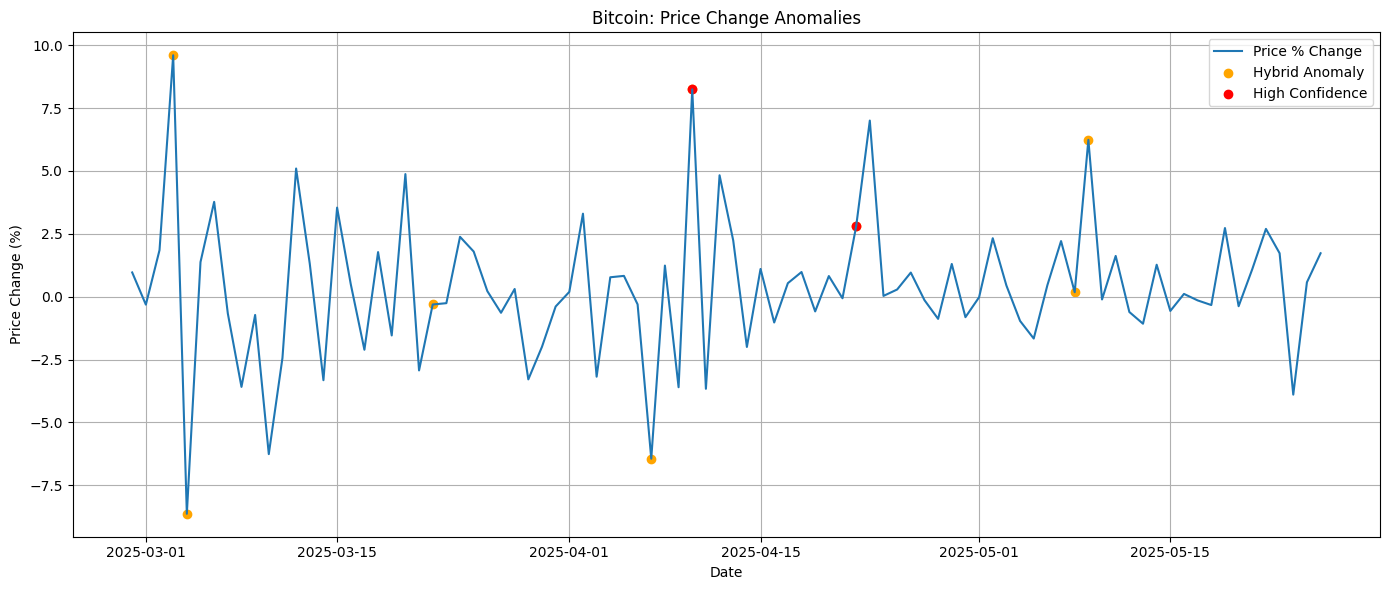

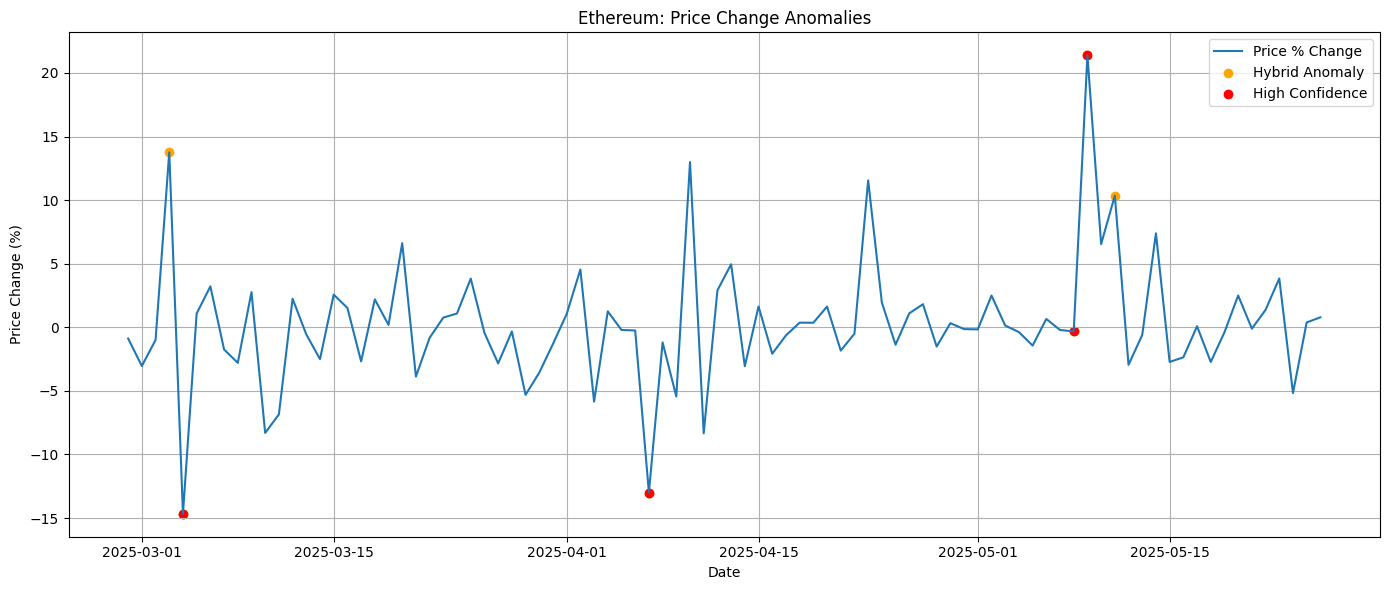

In [ ]:
import matplotlib.pyplot as plt

def plot_multivariate_anomalies(df, asset_label):
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df["Price Change (%)"], label="Price % Change", linewidth=1.5)
    plt.scatter(df[df["Hybrid Multivariate Anomaly"]].index,
                df[df["Hybrid Multivariate Anomaly"]]["Price Change (%)"],
                color='orange', label='Hybrid Anomaly')
    plt.scatter(df[df["High Confidence Multivariate"]].index,
                df[df["High Confidence Multivariate"]]["Price Change (%)"],
                color='red', label='High Confidence')
    plt.title(f"{asset_label}: Price Change Anomalies")
    plt.xlabel("Date")
    plt.ylabel("Price Change (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_multivariate_anomalies(btc_df, "Bitcoin")
plot_multivariate_anomalies(eth_df, "Ethereum")


## Visualise BTC and ETH Anomalies on the Same Graph

We plot daily `Price Change (%)` for both Bitcoin and Ethereum on the same graph.

Anomalies are overlaid using:
- Different colors for BTC and ETH
- Different markers for hybrid vs high-confidence anomalies

This allows us to visually compare **timing and magnitude** of anomalies across both assets.


In [ ]:
import matplotlib.pyplot as plt

def plot_combined_anomalies(btc_df, eth_df):
    plt.figure(figsize=(16, 6))

    # === Price Change Lines ===
    plt.plot(btc_df.index, btc_df["Price Change (%)"], label="BTC Price % Change", linewidth=1.5, color='blue')
    plt.plot(eth_df.index, eth_df["Price Change (%)"], label="ETH Price % Change", linewidth=1.5, color='green')

    # === Anomalies: Hybrid ===
    plt.scatter(btc_df[btc_df["Hybrid Multivariate Anomaly"]].index,
                btc_df[btc_df["Hybrid Multivariate Anomaly"]]["Price Change (%)"],
                color='orange', label="BTC Hybrid Anomaly", marker='o', zorder=5)

    plt.scatter(eth_df[eth_df["Hybrid Multivariate Anomaly"]].index,
                eth_df[eth_df["Hybrid Multivariate Anomaly"]]["Price Change (%)"],
                color='purple', label="ETH Hybrid Anomaly", marker='^', zorder=5)

    # === Anomalies: High Confidence ===
    plt.scatter(btc_df[btc_df["High Confidence Multivariate"]].index,
                btc_df[btc_df["High Confidence Multivariate"]]["Price Change (%)"],
                color='red', label="BTC High Confidence", marker='o', edgecolors='black', zorder=6)

    plt.scatter(eth_df[eth_df["High Confidence Multivariate"]].index,
                eth_df[eth_df["High Confidence Multivariate"]]["Price Change (%)"],
                color='darkmagenta', label="ETH High Confidence", marker='^', edgecolors='black', zorder=6)

    # === Labels and Layout ===
    plt.title("BTC vs ETH: Price Change % with Multivariate Anomalies")
    plt.xlabel("Date")
    plt.ylabel("Price Change (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


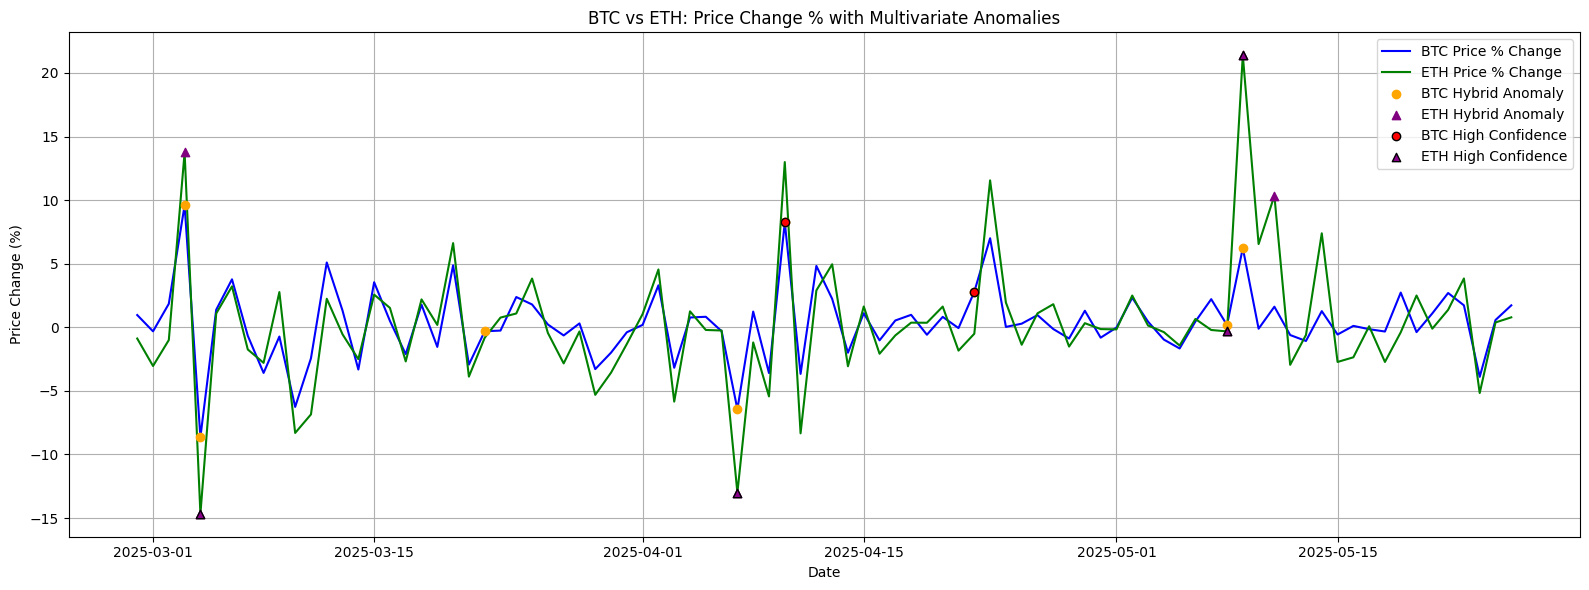

In [ ]:
plot_combined_anomalies(btc_df, eth_df)